In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
sequence_length = 10
num_hours_ahead = 5

In [3]:
# Load the arrays from the .npy files
X_train = np.load('data/X_train.npy')
y_train = np.load('data/y_train.npy')
X_val = np.load('data/X_val.npy')
y_val = np.load('data/y_val.npy')
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')

In [4]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2024-02-04 23:20:34.004002: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import Recall

In [6]:
# Indices for each class
indices_class_0 = np.where(y_train == 0)[0]
indices_class_1 = np.where(y_train == 1)[0]

# Data for each class
X_class_0 = X_train[indices_class_0]
X_class_1 = X_train[indices_class_1]
y_class_0 = y_train[indices_class_0]
y_class_1 = y_train[indices_class_1]

In [34]:

model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy', Recall()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 128)           68096     
                                                                 
 dropout_2 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 199809 (780.50 KB)
Trainable params: 199809 (780.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
num_epochs = 20
batch_size = 64

In [36]:
for epoch in range(num_epochs):
    # Randomly sample indices from the majority class to match the minority class size
    sampled_majority_indices = np.random.choice(indices_class_0, size=len(indices_class_1), replace=False)
    
    # Combine sampled majority indices with all minority class indices
    combined_indices = np.concatenate([sampled_majority_indices, indices_class_1])
    
    # Shuffle the combined indices
    np.random.shuffle(combined_indices)

    # Use the combined indices to create the training dataset for this epoch
    X_train_epoch = X_train[combined_indices]
    y_train_epoch = y_train[combined_indices]

    # Train the model on this epoch's data
    model.fit(X_train_epoch, y_train_epoch, epochs=1, batch_size=batch_size, validation_data=(X_val, y_val))


9471/9471 [==============================] - 66s 7ms/step - loss: 0.5377 - accuracy: 0.7207 - recall_1: 0.6250 - val_loss: 0.6430 - val_accuracy: 0.7143 - val_recall_1: 0.6626


# Evaluating the model

In [38]:
test_loss, test_accuracy, test_recall = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Recall: {test_recall}")

6607/6607 [==============================] - 21s 3ms/step - loss: 0.6423 - accuracy: 0.7137 - recall_1: 0.6667
Test Loss: 0.6422663331031799
Test Accuracy: 0.7136802673339844
Test Recall: 0.6666896939277649


In [39]:
predictions = model.predict(X_test)
predicted_classes = (predictions >= 0.5).astype(int).flatten()

6607/6607 [==============================] - 18s 2ms/step


In [40]:
from tensorflow.math import confusion_matrix

conf_matrix = confusion_matrix(y_test, predicted_classes)
print(conf_matrix)

tf.Tensor(
[[102665  36426]
 [ 24106  48217]], shape=(2, 2), dtype=int32)


In [41]:
np.array([['True Negative', 'False Positive'],
 ['False Negative', 'True Positive']])

array([['True Negative', 'False Positive'],
       ['False Negative', 'True Positive']], dtype='<U14')

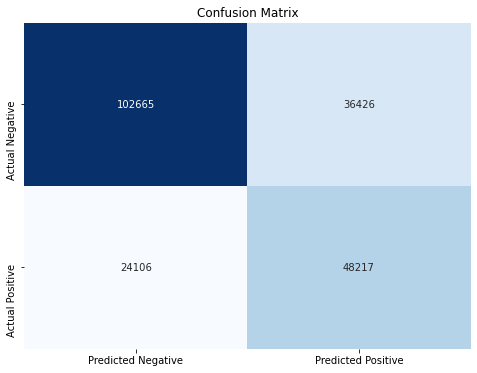

In [9]:
# Since your confusion matrix is already a TensorFlow tensor, convert it to a numpy array for visualization.
conf_matrix_np = np.array([[102665 , 36426]
 , [ 24106,  48217]])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_np, annot=True, fmt="d", cmap='Blues', cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])


plt.title('Confusion Matrix')
plt.show()

In [43]:
# Extracting the counts from the confusion matrix
TN, FP, FN, TP = conf_matrix.numpy().ravel()

# Calculating metrics
Accuracy = (TP + TN) / (TP + TN + FP + FN)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1_Score = 2 * (Precision * Recall) / (Precision + Recall)

print(f'Accuracy: {Accuracy}')
print(f'Precision: {Precision}')
print(f'Recall: {Recall}')
print(f'F1 Score: {F1_Score}')

Accuracy: 0.713680267153547
Precision: 0.5696513592382123
Recall: 0.6666897114334306
F1 Score: 0.6143623459857549


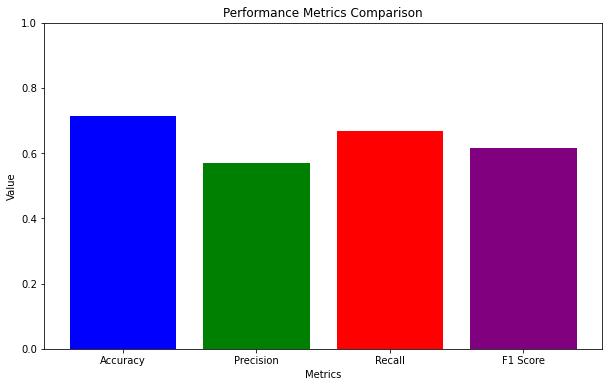

In [44]:

# Metrics values
metrics_values = [Accuracy, Precision, Recall, F1_Score]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'red', 'purple'])

plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Performance Metrics Comparison')
plt.ylim(0, 1)  # Since metric values range from 0 to 1
plt.show()

# AUROC

In [45]:
# Assuming `model` is your trained TensorFlow model and `X_test` is your test dataset
y_probabilities = model.predict(X_test).ravel()


6607/6607 [==============================] - 16s 2ms/step


In [46]:
y_probabilities

array([0.8808977 , 0.87771165, 0.87703174, ..., 0.34179017, 0.33736566,
       0.33493122], dtype=float32)

In [47]:
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate AUROC
auroc = roc_auc_score(y_test, y_probabilities)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)


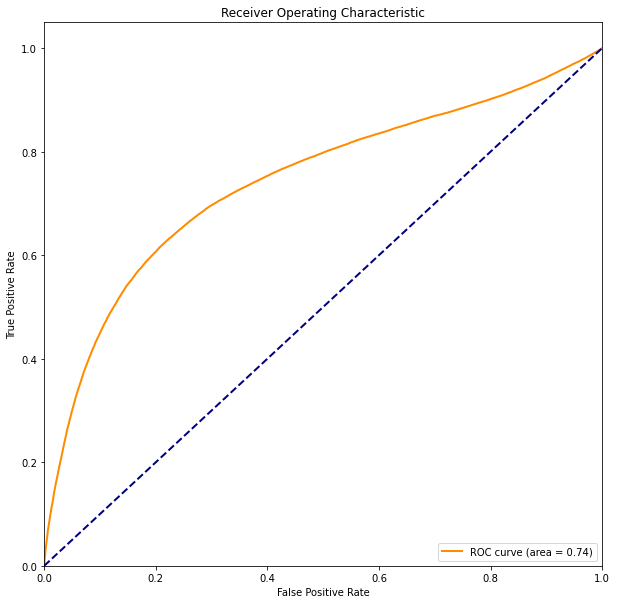

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10)) 
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()